* Whitaker Behrens
* BrainStation Data Science
* Capstone

# Pneumonia Image Classification with Neural Networks

**Table of Contents:**

* [Introduction](#intro)
* [Importing Images](#1)
* [Initial Processing and EDA](#2)
* [Initial Modeling](#3)
* [Evaluating First Model](#4)
* [Second Model - Weighted Classes](#5)
* [Third Model - SMOTE](#6)
* [Re-Importing Images with Separated Positive Class](#7)
* [Fourth Model - Multiclass](#8)
* [Evaluating Multiclass Model](#9)
* [Fifth Model - Only Positive Classes](#10)
* [Best Model Visual Evaluation of Images](#11)
* [Summary and Conclusions](#12)

# <a class='anchor' id='intro'></a> Introduction

My capstone project involved modeling X-ray image data of pediatric patients - either negative/normal or positive for a Pneumonia infection of the lungs. The underlying question I set out to answer was whether a neural network (specifically Convolutional Neural Networks) could be trained to quickly identify and flag the presence of Pneumonia in a large volume of X-ray images, which could then be verified by a trained professional. In order to do this, my goal was to train a series of models to determine how well the computer could perform on a sample set of X-ray images, identifying the performance metrics of each model, and attempting to determine what if any specific features of the images might be more likely to make the computer mis-classify the data.

The environment needed to run the notebook is an augmented version of the `deeplearning` environment that we created for lectures during the semester, with a few additional tools to help with importing the image data and evaluate model results. The environment can be cloned from the accompanying `capstone_env.txt` file included with the notebook.

The image data for the project is hosted in a publicly-accessible AWS S3 bucket, and can be downloaded at the following link: [https://wbehrens-bstn-capstone-images.s3.amazonaws.com/data.zip](https://wbehrens-bstn-capstone-images.s3.amazonaws.com/data.zip)

To run the notebook, please download the .zip file from the S3 bucket, unzip the file, and move the `data` folder into the same working directory as this notebook.

To get started, we'll import all the tools and libraries we'll need throughout the notebook.

In [1]:
# import libraries - this will take a couple seconds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import cv2
import random

# import sklearn libraries

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# import SMOTE library

from imblearn.over_sampling import SMOTE

# import tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# set random states for reproducability

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# <a class='anchor' id='1'></a> Importing Images

The first thing we need to do is import the images from their respective subdirectories in the `data` file. There are two subdirectories - `negative` and `positive` - that denote the class for each image. We need to make sure each image file is imported with a corresponding label that indicates which subdirectory it originated from. The function defined below was adapted from a number of tutorials, Stack Overflow posts, and trial and error.

In [2]:
# import images with labels - this will take roughly 15 seconds

data_dir = 'data'
categories = ['negative', 'positive']

img_size=245

labeled_data = []

def create_labeled_data():
    
    '''
    Function to import images from respective subdirectories, using each subdirectory to indicate class.
    
    No user input, takes directory path to parent directory and class subdirectories and appends to the labeled_data list.
    '''
    
    for category in categories:
    
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                labeled_data.append([new_array, class_num])
            except Exception:
                pass
            
create_labeled_data()

Now that the images have all been imported, we can check to see how many there are in total. We'll do this by checking the length of the labeled_data list.

In [3]:
# check imported images

print(len(labeled_data))

5856


Slightly fewer than 5,900 images in total. Next we'll shuffle the imported images to introduce some randomness into the system, which will make our trained models more robust.

In [4]:
# shuffle the images

random.shuffle(labeled_data)

In [5]:
# check labels

for image in labeled_data[:10]:
    print(image[1])

0
0
1
1
1
1
1
1
1
1


Initial importation of the images done, we can move on to processing the data into a format that can be used for modeling.

# <a class='anchor' id='2'></a> Processing Data for Initial Modeling

We'll start by splitting up the `labeled_data` into `X` and `y` variables, `X` being the images themselves and `y` being the corresponding class label. We'll then convert these to arrays which are compatible with training a CNN.

In [6]:
# create X and y variables

X = []
y = []

for image, label in labeled_data:
    X.append(image)
    y.append(label)

# convert to array
    
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

In the interest of exploratory analysis, we can investigate the class distribution using the `np.unique` method as well as visualing the class split.

In [7]:
# check class distribution

print(np.unique(y, return_counts=True))

(array([0, 1]), array([1583, 4273]))


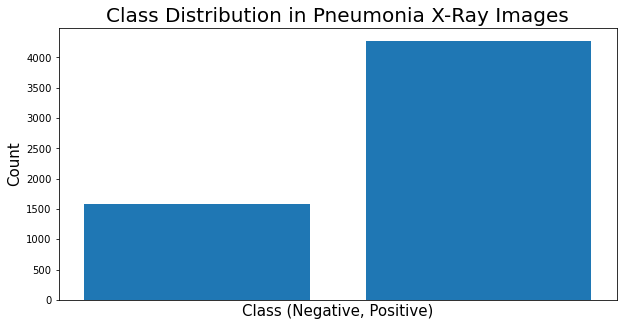

In [8]:
# visualize class distribution

plt.figure(figsize=(10,5))
plt.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1])
plt.title('Class Distribution in Pneumonia X-Ray Images', size=20)
plt.xlabel('Class (Negative, Positive)', size=15)
plt.ylabel('Count', size=15)
plt.xticks([])
plt.show()

It looks like there's slightly better than a 3:1 class distribution between the Positive class and the Negative class. As class imbalances go, this isn't the worst for modeling and us such in my estimation does not require immediate action to address before initial modeling. This will be an area of focus however for how we can improve the performance of the model once the initial model gives us a baseline of performance.

Next we'll split the data into `train` and `test` sets. Since the overall number of images in the dataset is only several thousand, I've opted to reserve larger portions for the `test` and `validation` sets. The entire dataset will be split into 50-25-25 chunks, meaning the `train` set will contain 50% of the total images, while the `test` and `validation` sets will roughly evenly split the other half for 25% of the total images each.

In [9]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
# check shapes of split sets

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4392, 245, 245, 1) (4392,)
(1464, 245, 245, 1) (1464,)


We'll scale the pixel intensity values for the `X` datasets to help normalize the images for training the models.

In [11]:
# scale

X_train = X_train/255
X_test = X_test/255

In [12]:
# check pixel range

print(f'X range: {X_train.min()}-{X_train.max()}')

X range: 0.0-1.0


We now have the data in workable format for intial modeling and evaluation.

# <a class='anchor' id='3'></a> Initial Modeling

For our initial model, we're starting with a relatively standard architecture for a CNN. This will be a sequential model with the first convolutional layer made up of 32 filters, a 3x3 kernel size, ReLU activation, 2x2 pooling, and 25% dropout to prevent overfitting. The second layer will be another convolutional layer identical to the first aside from using 64 filters. We'll then use a flattening layer, before adding two dense layers with 128 and 64 nodes respectively each also with ReLU activation. Finally this will be fed to an output layer with a single node and Sigmoid activation, for use with our binary classification problem.

In [13]:
# instantiate model

basic_model = Sequential()

# add layers with convolution, pooling, and dropout

basic_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_model.add(Dropout(0.25))

basic_model.add(Conv2D(64, (3, 3), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_model.add(Dropout(0.25))

# add flatten layer

basic_model.add(Flatten())

# add dense layers

basic_model.add(Dense(128, activation='relu'))
basic_model.add(Dense(64, activation='relu'))
basic_model.add(Dense(1, activation='sigmoid'))

# check summary

basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 222784)            0

2022-04-01 19:53:11.188026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We'll compile the model with Binary Cross Entropy loss and Adam optimizer, continuing with the standard theme.

In [14]:
# compile

basic_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

Finally, we'll train the model for ten epochs. We have to specify a validation split of 33% of the `train` dataset, but when compared to the entire dataset as a whole this equates to roughly one quarter (25%) of the full dataset.

In [15]:
# train with 0.33 validation_split - this will take 10-15 minutes

basic_model.fit(X_train, y_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

2022-04-01 19:53:11.577701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
30/30 [==============================] - 112s 4s/step - loss: 2.1607 - accuracy: 0.6275 - val_loss: 0.5789 - val_accuracy: 0.7386
Epoch 2/10
30/30 [==============================] - 118s 4s/step - loss: 0.5164 - accuracy: 0.7427 - val_loss: 0.2830 - val_accuracy: 0.8924
Epoch 3/10
30/30 [==============================] - 115s 4s/step - loss: 0.2671 - accuracy: 0.8771 - val_loss: 0.1953 - val_accuracy: 0.9276
Epoch 4/10
30/30 [==============================] - 114s 4s/step - loss: 0.1885 - accuracy: 0.9260 - val_loss: 0.1675 - val_accuracy: 0.9386
Epoch 5/10
30/30 [==============================] - 115s 4s/step - loss: 0.1398 - accuracy: 0.9447 - val_loss: 0.1517 - val_accuracy: 0.9421
Epoch 6/10
30/30 [==============================] - 116s 4s/step - loss: 0.1239 - accuracy: 0.9542 - val_loss: 0.1642 - val_accuracy: 0.9414
Epoch 7/10
30/30 [==============================] - 113s 4s/step - loss: 0.1268 - accuracy: 0.9556 - val_loss: 0.1349 - val_accuracy: 0.9503
Epoch 8/10
30

It looks like our model is achieving a 96.3% training accuracy and 95.1% validation accuracy. Not bad for a preliminary model using fairly standard architecture in a relatively un-modified inital dataset. We can now further evaluate this initial model and get some additional baseline performance metrics.

# <a class='anchor' id='4'></a> Evaluating First Model

We'll check the trained model against our 25% `test` set.

In [16]:
# test score - this will take a few seconds

score = basic_model.evaluate(X_test, y_test, verbose=0)

print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.14625588059425354
Test accuracy: 0.943306028842926


Our first trained model is getting a 94.3% test accuracy - very good performance considering simply guessing each image to be Positive would only be correct roughly 70% of the time. We can also see the model likely isn't overfitting, as our training accuracy and testing accuracy are separate by less than two percentage points. We can do some additional evaluation by checking the model predictions against the true class labels.

In [17]:
# get predictions - this will take a few seconds

y_pred = basic_model.predict_classes(X_test)

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [18]:
# viusualize confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
)

cm_df

,Predicted Negative,Predicted Positive
True Negative,379,34
True Positive,49,1002


In [19]:
# calculate precision and recall

tp = cm[1,1]
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]

prec = round(tp/(tp+fp), 4)*100
rec = round(tp/(tp+fn), 4)*100

print(f'Model precision: {prec}')
print(f'Model recall: {rec}')

Model precision: 96.72
Model recall: 95.34


Our first model is scoring fairly well on precision and recall as well. Given the practical application for this proposed system, going forward we want to keep an eye on overall accuracy as well as the model recall: That is, how many of the positive cases the model caught. In a medical context, a False Positive that only requires a quick secondary evaluation by a doctor to be dismissed is much less potentially consequential than a False Negative, which could result in a patient who actually needs further attention and treatment falling through the cracks to catastrophic consequences - up to and including the loss of life.

Now that we have some baseline metrics, we can work on trying to improve these numbers and see how well the computer can do with this problem.

One of the issues with the dataset we can work on addressing is the current ~3:1 class imbalance. There are a number of ways to address this issue with a dataset. Through a bit of research and reading, I was able to identify two of the most commonly suggested approaches - those being to train the model with weighted classes, and the SMOTE technique. We'll start with attempting to train the model with weighted classes.

# <a class='anchor' id='5'></a> Second Model with Weighted Classes

One of the most common approaches for addressing a class imbalance when training a model is to weight the classes. This doesn't change the overall number of observations in the datasets, but it instructs the model to 'pay more attention' to the minority class images during training, putting more emphasis on the effect each minority class image when the model is developing the connection weights between nodes. We can include this in our model by calculating the class weights based on the proportion of the classes to each other, using the `sklearn` library.

In [20]:
# calculate balanced class weights

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)

# check

class_weights

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([1.87692308, 0.68156425])

We'll have to convert this array into a dictionary to be compatible with our CNN model.

In [21]:
# convert class_weights to dict

class_weights = dict(enumerate(class_weights))

# check

class_weights

{0: 1.876923076923077, 1: 0.6815642458100558}

Now we can instatiate and compile a new CNN model. The architecture of this CNN is identical to our initial model, so we can isolate the class weights as the only different variable effecting the model.

In [22]:
# instantiate new model

weighted_model = Sequential()

# add layers

weighted_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
weighted_model.add(MaxPooling2D(pool_size=(2, 2)))
weighted_model.add(Dropout(0.25))

weighted_model.add(Conv2D(64, (3, 3), activation='relu'))
weighted_model.add(MaxPooling2D(pool_size=(2, 2)))
weighted_model.add(Dropout(0.25))

# flatten

weighted_model.add(Flatten())

# add dense layers

weighted_model.add(Dense(128, activation='relu'))
weighted_model.add(Dense(64, activation='relu'))
weighted_model.add(Dense(1, activation='sigmoid'))

weighted_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 222784)           

In [23]:
# compile

weighted_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

We'll now train the model as before, this time passing in our `class_weights` dictionary as an argument to see if we can get the model the pay closer attention to the minority `negative` class.

In [24]:
# train - this will take 10-15 minutes

weighted_model.fit(X_train, y_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33,
                class_weight=class_weights)

Epoch 1/10
30/30 [==============================] - 118s 4s/step - loss: 1.7900 - accuracy: 0.5139 - val_loss: 0.6475 - val_accuracy: 0.8524
Epoch 2/10
30/30 [==============================] - 119s 4s/step - loss: 0.4920 - accuracy: 0.8305 - val_loss: 0.2630 - val_accuracy: 0.8883
Epoch 3/10
30/30 [==============================] - 119s 4s/step - loss: 0.2454 - accuracy: 0.8965 - val_loss: 0.1815 - val_accuracy: 0.9317
Epoch 4/10
30/30 [==============================] - 121s 4s/step - loss: 0.1718 - accuracy: 0.9386 - val_loss: 0.1954 - val_accuracy: 0.9366
Epoch 5/10
30/30 [==============================] - 120s 4s/step - loss: 0.1503 - accuracy: 0.9467 - val_loss: 0.1435 - val_accuracy: 0.9462
Epoch 6/10
30/30 [==============================] - 120s 4s/step - loss: 0.1000 - accuracy: 0.9661 - val_loss: 0.1588 - val_accuracy: 0.9428
Epoch 7/10
30/30 [==============================] - 119s 4s/step - loss: 0.1210 - accuracy: 0.9462 - val_loss: 0.1574 - val_accuracy: 0.9462
Epoch 8/10
30

Let's check the test accuracy of the weighted model against our initial model.

In [25]:
# evaluate - this will take a few seconds

weighted_score = weighted_model.evaluate(X_test, y_test, verbose=0)

print(f'Basic model test accuracy: {score[1]}')
print(f'Weighted model test accuracy: {weighted_score[1]}')

Basic model test accuracy: 0.943306028842926
Weighted model test accuracy: 0.9419398903846741


We see the test accuracy of the weighted model has actually decreased by 0.2% from 94.3% to 94.1%. Not a great start. We'll take a look at the precision and recall as well.

In [26]:
# predict and visualize confusion matrix - this will take a few seconds

y_pred_weight = weighted_model.predict_classes(X_test)

cm_weight = confusion_matrix(y_test, y_pred_weight)

cm_weight_df = pd.DataFrame(
    cm_weight,
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
)

cm_weight_df

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Predicted Negative,Predicted Positive
True Negative,375,38
True Positive,47,1004


In [27]:
# precision and recall

tp_w = cm_weight[1,1]
tn_w = cm_weight[0,0]
fp_w = cm_weight[0,1]
fn_w = cm_weight[1,0]

prec_weight = round(tp_w/(tp_w+fp_w), 4)*100
rec_weight = round(tp_w/(tp_w+fn_w), 4)*100

print(f'Original model precision, recall: {prec, rec}')
print(f'Weighted model precision, recall: {prec_weight, rec_weight}')

Original model precision, recall: (96.72, 95.34)
Weighted model precision, recall: (96.35000000000001, 95.53)


As we can see, the weighted model did do slightly better on recall, but it amounted to only an additional two images from the `positive` class being correctly classified. Not a very impressive improvement.

Luckily, class weighting isn't the only technique recommended for dealing with imbalanced datasets. One other commonly recommended technique is the Snythetic Minority Oversampling TEchnique, or SMOTE. We'll try this technique next.

# <a class='anchor' id='6'></a> Third Model with SMOTE

The SMOTE technique physically alters the class balance by undersampling the majority class and creating additional synthetic data points (in our case, images) to create perfectly or near-perfectly balanced class sizes. This can help eliminate the bias created by an overwhelming majority class when training a model. We'll start by instantiating the SMOTE sampler from the `imblearn` library.

In [28]:
# instantiate SMOTE sampler

sm = SMOTE(random_state=42)

We'll have to reshape our image arrays to be compatible with the SMOTE sampler.

In [29]:
# reshape train array for SMOTE

X_train_reshaped = X_train.reshape(4392, 60025)

Now we fit the training datasets and resample using SMOTE.

In [30]:
# fit and resample - this will take a few seconds

X_smote, y_smote = sm.fit_resample(X_train_reshaped, y_train)

Of course, we'll have to reshape the image array back to the shape compatible with our CNN model.

In [31]:
# reshape SMOTE array for model

X_smote = X_smote.reshape(X_smote.shape[0], 245, 245, 1)

# check

print(X_smote.shape)
print(y_smote.shape)

(6444, 245, 245, 1)
(6444,)


Now we can check our new SMOTEd class distribution.

(array([0, 1]), array([3222, 3222]))


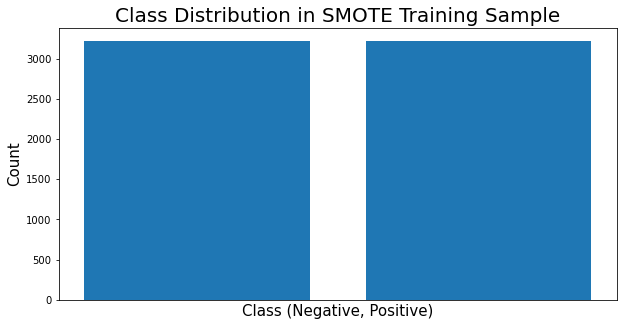

In [32]:
# recheck class distribution

print(np.unique(y_smote, return_counts=True))

# visualize

plt.figure(figsize=(10,5))
plt.bar(np.unique(y_smote, return_counts=True)[0], np.unique(y_smote, return_counts=True)[1])
plt.title('Class Distribution in SMOTE Training Sample', size=20)
plt.xlabel('Class (Negative, Positive)', size=15)
plt.ylabel('Count', size=15)
plt.xticks([])
plt.show()

Our class balance has been changed to a perfect 1:1 ratio by undersampling the majority class from 4,273 to 3,222, and increasing the minority class from 1,583 to the same 3,222 using additional SMOTE synthetic datapoints.

We'll now model with our new balanced dataset, again using the same architecture as our initial model to isolate the SMOTE dataset as our variable being tested for improvement.

In [33]:
# instantiate new model

smote_model = Sequential()

# add layers

smote_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
smote_model.add(MaxPooling2D(pool_size=(2, 2)))
smote_model.add(Dropout(0.25))

smote_model.add(Conv2D(64, (3, 3), activation='relu'))
smote_model.add(MaxPooling2D(pool_size=(2, 2)))
smote_model.add(Dropout(0.25))

# flatten

smote_model.add(Flatten())

# add dense layers

smote_model.add(Dense(128, activation='relu'))
smote_model.add(Dense(64, activation='relu'))
smote_model.add(Dense(1, activation='sigmoid'))

# summary

smote_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 222784)           

In [34]:
# compile

smote_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [35]:
# train - this will take about 30 minutes

smote_model.fit(X_smote, y_smote,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

Epoch 1/10
44/44 [==============================] - 181s 4s/step - loss: 1.0229 - accuracy: 0.6617 - val_loss: 0.8424 - val_accuracy: 0.4843
Epoch 2/10
44/44 [==============================] - 176s 4s/step - loss: 0.2521 - accuracy: 0.8978 - val_loss: 0.5466 - val_accuracy: 0.7621
Epoch 3/10
44/44 [==============================] - 176s 4s/step - loss: 0.1502 - accuracy: 0.9377 - val_loss: 0.1924 - val_accuracy: 0.9276
Epoch 4/10
44/44 [==============================] - 175s 4s/step - loss: 0.1344 - accuracy: 0.9474 - val_loss: 0.4369 - val_accuracy: 0.8171
Epoch 5/10
44/44 [==============================] - 176s 4s/step - loss: 0.1198 - accuracy: 0.9546 - val_loss: 0.2349 - val_accuracy: 0.9064
Epoch 6/10
44/44 [==============================] - 176s 4s/step - loss: 0.0822 - accuracy: 0.9741 - val_loss: 0.2881 - val_accuracy: 0.8806
Epoch 7/10
44/44 [==============================] - 176s 4s/step - loss: 0.0872 - accuracy: 0.9660 - val_loss: 0.2706 - val_accuracy: 0.8872
Epoch 8/10
44

We're seeing some oddly erratic behavior from the `validation` set accuracy in this model, though still a steady increase in accuracy performance from the `train` set. Let's take a look at the `test` accuracy and compare with with our initial baseline model.

In [36]:
# evaluate - this will take a few seconds

smote_score = smote_model.evaluate(X_test, y_test, verbose=0)

print(f'Basic model test accuracy: {score[1]}')
print(f'SMOTE model test accuracy: {smote_score[1]}')

Basic model test accuracy: 0.943306028842926
SMOTE model test accuracy: 0.9405737519264221


As seen in our weighted class model, we've slightly decreased the testing accuracy of the model by about 0.3% from 94.3% baseline to 94.0% with our SMOTE model. Let's take a look at the other metrics and see where that accuracy decrease might be coming from.

In [37]:
# confusion matrix - this will take a few seconds

y_pred_smote = smote_model.predict_classes(X_test)

cm_smote = confusion_matrix(y_test, y_pred_smote)

cm_smote_df = pd.DataFrame(
    cm_smote,
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
)

cm_smote_df

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Predicted Negative,Predicted Positive
True Negative,391,22
True Positive,65,986


In [38]:
# precision and recall

tp_s = cm_smote[1,1]
tn_s = cm_smote[0,0]
fp_s = cm_smote[0,1]
fn_s = cm_smote[1,0]

prec_smote = round(tp_s/(tp_s+fp_s), 4)*100
rec_smote = round(tp_s/(tp_s+fn_s), 4)*100

print(f'Original model precision, recall: {prec, rec}')
print(f'Weighted model precision, recall: {prec_weight, rec_weight}')
print(f'SMOTE model precision, recall: {prec_smote, rec_smote}')

Original model precision, recall: (96.72, 95.34)
Weighted model precision, recall: (96.35000000000001, 95.53)
SMOTE model precision, recall: (97.82, 93.82000000000001)


Compared to our original model, not only have we decreased the overall accuracy our SMOTE model is getting worse recall too, adding nearly a third more False Negative misclassifications. This is clearly moving in the wrong direction.

It was at this time pointed out to me (thank you Boris Shabash) that the model may be having difficulty distinguishing between the `negative` class and certain parts of the `positive` class, as the `positive` images are actually made up of two different types of Pneumonia infection - bacterial, and viral. Until now we had just been lumping both types of infections together into the `positive` class, but because bacterial Pneumonia infections present visually differently in X-ray imaging than viral infections, the model may be misclassifying more of the `positive` viral images and harming the recall metric, producing more False Negatives. For our next model, we'll split up the `positive` class into separate `bacteria` and `virus` classes turning our binary classification problem to a multiclass problem.

# <a class='anchor' id='7'></a> Splitting Positive Class into Bacterial and Viral Classes

In order to split up the `positive` class into separate `bacteria` and `virus` classes we'll have to re-import the images from the subdirectories, using part of the file name itself from the `positive` directory to indicate whether an image represents a bacterial or viral Pneumonia infection. This turned out to be much easier said than done. The below pair of importation functions were adapted from numerous tutorials, Stack Overflow posts, and much more trial and error.

In [39]:
# define import functions

def load_negative(neg_path):
    
    '''
    Function to import images from the negative images subdirectory with labels.
    
    User input: File path to the negative subdirectory.
    
    Output: neg_labels and neg_images, arrays that respectively hold the subdirectory label and image arrays.
    '''
    
    neg_files = np.array(os.listdir(neg_path))
    neg_labels = np.array(['negative']*len(neg_files))
    
    neg_images = []
    
    for image in neg_files:
        try:
            image = cv2.imread(neg_path + image)
            image = cv2.resize(image, dsize=(img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            neg_images.append(image)
        except Exception:
            pass
        
    neg_images = np.array(neg_images)
    
    return neg_images, neg_labels

def load_positive(pos_path):
    
    '''
    Function to import images from the positive images subdirectory, using part of the file name to indicate class label.
    
    User Input: File path to the positive subdirectory.
    
    Output: pos_labels and pos_images, arrays that respectively hold the class label from file name and image arrays.
    '''
    
    pos_files = np.array(os.listdir(pos_path))
    pos_labels = np.array([pos_file.split('_')[1] for pos_file in pos_files])
    
    pos_images = []
    
    for image in pos_files:
        try:
            image = cv2.imread(pos_path + image)
            image = cv2.resize(image, dsize=(img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pos_images.append(image)
        except Exception:
            pass
        
    pos_images = np.array(pos_images)
    
    return pos_images, pos_labels

In [40]:
# import images and labels this will take roughly 20 seconds

neg_images, neg_labels = load_negative('data/negative/')
pos_images, pos_labels = load_positive('data/positive/')

Now that we have our images and corresponding labels in arrays, we'll concatenate them together to create our new `X` and `y` variables, which we'll refer to as `X2` and `y2`. We can check the class distribution of our new multiclass dataset and visualize it as well.

In [41]:
# create X and y variables

X2 = np.append(neg_images, pos_images, axis=0)
y2 = np.append(neg_labels, pos_labels)

# check

print(X2.shape, y2.shape)
print(np.unique(y2, return_counts=True))

(5856, 245, 245) (5856,)
(array(['bacteria', 'negative', 'virus'], dtype='<U8'), array([2780, 1583, 1493]))


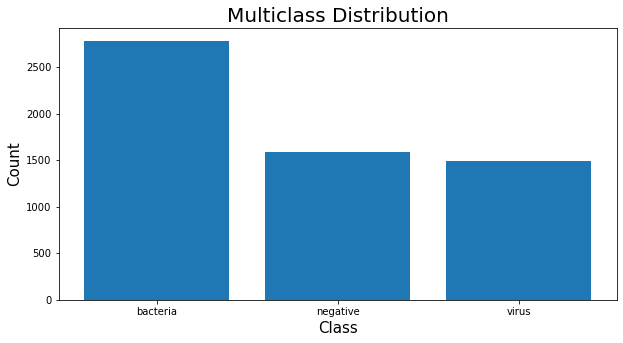

In [42]:
# visualize multiclass distribution

plt.figure(figsize=(10,5))
plt.bar(np.unique(y2, return_counts=True)[0], np.unique(y2, return_counts=True)[1])
plt.title('Multiclass Distribution', size=20)
plt.xlabel('Class', size=15)
plt.ylabel('Count', size=15)
plt.show()

It looks like we have a roughly 2:1:1 class distribution with roughly equal numbers of `negative` and `virus` images, and a little less than twice as many `bacteria` images.

We'll have to reshape our image array to add the grayscale color channel for our model.

In [43]:
# reshape X for model

X2 = X2.reshape(X2.shape[0], 245, 245, 1)

# check

print(X2.shape)

(5856, 245, 245, 1)


We can now split the data and scale the pixel intensity to process for modeling.

In [44]:
# split data

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42)

# check

print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

(4392, 245, 245, 1) (4392,)
(1464, 245, 245, 1) (1464,)


In [45]:
# scale

X2_train = X2_train/255
X2_test = X2_test/255

# check

print(f'X range: {X2_train.min()}-{X2_train.max()}')

X range: 0.0-1.0


Unfortunately the string class labels aren't compatible with training our CNN model, so we'll have to use the One Hot Encoder to change our `y2` variable to a numeric array. This will require reshaping the array to be compatible with the encoder, fitting the encoder on the training data, then transforming both the training and test set.

In [46]:
# reshape y2_train and y2_test for encoder

y2_train = y2_train[:, np.newaxis]
y2_test = y2_test[:, np.newaxis]

In [47]:
# instantiate OHE

ohe = OneHotEncoder(sparse=False)

# encode labels for model

y2_train = ohe.fit_transform(y2_train)
y2_test = ohe.transform(y2_test)

In [48]:
# check

print(y2_train.shape, y2_test.shape)

(4392, 3) (1464, 3)


We now have the datasets processed and in proper condition to be modeled.

# <a class='anchor' id='8'></a> Multiple Positive Classes Modeling

We'll model using nearly the same standard architecture we've been using. The one necessary difference is to change our output layer from a single node with Sigmoid activation to a three-node layer with Softmax activation, to indicate one of our three potential classes. We'll also have to compile the model with Categorical as opposed to Binary Cross Entropy. Aside from these necessary changes from a binary to multiclass input dataset, our model architecture remains unchanged.

In [49]:
# instantiate new model

mul_pos_model = Sequential()

# add layers

mul_pos_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
mul_pos_model.add(MaxPooling2D(pool_size=(2, 2)))
mul_pos_model.add(Dropout(0.25))

mul_pos_model.add(Conv2D(64, (3, 3), activation='relu'))
mul_pos_model.add(MaxPooling2D(pool_size=(2, 2)))
mul_pos_model.add(Dropout(0.25))

# flatten

mul_pos_model.add(Flatten())

# add dense layers

mul_pos_model.add(Dense(128, activation='relu'))
mul_pos_model.add(Dense(64, activation='relu'))
mul_pos_model.add(Dense(3, activation='softmax'))

# summary

mul_pos_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 222784)           

In [50]:
# compile

mul_pos_model.compile(loss = 'categorical_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [51]:
# train - this will take 15-20 minutes

mul_pos_model.fit(X2_train, y2_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

Epoch 1/10
30/30 [==============================] - 122s 4s/step - loss: 3.6415 - accuracy: 0.3880 - val_loss: 1.0501 - val_accuracy: 0.5379
Epoch 2/10
30/30 [==============================] - 121s 4s/step - loss: 0.7998 - accuracy: 0.6754 - val_loss: 0.6400 - val_accuracy: 0.7414
Epoch 3/10
30/30 [==============================] - 119s 4s/step - loss: 0.5812 - accuracy: 0.7583 - val_loss: 0.5457 - val_accuracy: 0.7628
Epoch 4/10
30/30 [==============================] - 120s 4s/step - loss: 0.5072 - accuracy: 0.7872 - val_loss: 0.5393 - val_accuracy: 0.7745
Epoch 5/10
30/30 [==============================] - 109s 4s/step - loss: 0.4640 - accuracy: 0.7933 - val_loss: 0.5685 - val_accuracy: 0.7552
Epoch 6/10
30/30 [==============================] - 109s 4s/step - loss: 0.4530 - accuracy: 0.8090 - val_loss: 0.5153 - val_accuracy: 0.7897
Epoch 7/10
30/30 [==============================] - 108s 4s/step - loss: 0.4053 - accuracy: 0.8219 - val_loss: 0.5113 - val_accuracy: 0.7876
Epoch 8/10
30

It does appear as though something is getting this model more confused than previously. Let's take a look at the metrics and see if we can figure out what's happening.

# <a class='anchor' id='9'></a> Evaluating Multiclass Model

We'll start with checking the test accuracy of our new multiclass model.

In [52]:
# accuracy score - this will take a few seconds

mul_pos_score = mul_pos_model.evaluate(X2_test, y2_test, verbose=0)

print(f'Multiclass test loss: {mul_pos_score[0]}')
print(f'Multiclass test accuracy: {mul_pos_score[1]}')

Multiclass test loss: 0.5400427579879761
Multiclass test accuracy: 0.7752732038497925


Compared to our previous binary classification models, overall this model is performing less impressively. It is however still performing fairly well, considering blindly guessing that each image belonged to the `bacteria` class would result in a correct guess only roughly 47% of the time - about a 30 point increase. We'll dive a bit deeper into the model metrics and see where it's getting tripped up.

In [53]:
# predict - this will take a few seconds

y2_pred = mul_pos_model.predict(X2_test)

# revert to class labels

y2_pred = ohe.inverse_transform(y2_pred)

y2_test_labels = ohe.inverse_transform(y2_test)

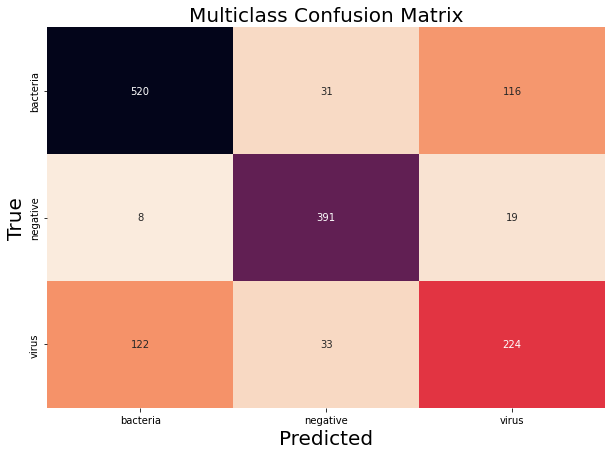

In [54]:
# visualize confusion matrix

mul_pos_cm = confusion_matrix(y2_test_labels, y2_pred)

plt.figure(figsize=(10,7))
sns.heatmap(mul_pos_cm, xticklabels=['bacteria', 'negative', 'virus'], yticklabels=['bacteria', 'negative', 'virus'], fmt='d', annot=True, cbar=False, cmap='rocket_r')
plt.title('Multiclass Confusion Matrix', size=20)
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

In [55]:
# calculate metrics

print(classification_report(y2_test_labels, y2_pred, digits=4))

              precision    recall  f1-score   support

    bacteria     0.8000    0.7796    0.7897       667
    negative     0.8593    0.9354    0.8958       418
       virus     0.6240    0.5910    0.6070       379

    accuracy                         0.7753      1464
   macro avg     0.7611    0.7687    0.7642      1464
weighted avg     0.7714    0.7753    0.7727      1464



This result was, quite bluntly, an astonishing surprise. Recall, our hypothesis was that the model is struggling to distinguish between the `negative` and `virus` classes, due to the more subtle presentation of a viral Pneumonia infection in X-ray imaging as compared to a bacterial infection. Based on these more in-depth metrics, by allowing the model to distinguish between the two different positive cases it's actually been able to reduce the number of misclassified `negative` images.

In [56]:
# comparing accuracy

print(f'Basic model test accuracy: {score[1]}')
print(f'Weighted model test accuracy: {weighted_score[1]}')
print(f'SMOTE model test accuracy: {smote_score[1]}')
print(f'Multiclass model test accuracy: {mul_pos_score[1]}')

Basic model test accuracy: 0.943306028842926
Weighted model test accuracy: 0.9419398903846741
SMOTE model test accuracy: 0.9405737519264221
Multiclass model test accuracy: 0.7752732038497925


The multiclass model is clearly struggling compared to the iterations of our binary class model, but it's having a relatively easy time differing between the `negative` class and either of the two positive classes. The model has notable difficulty however when asked to discern what type of Pneumonia infection is present. To further explore this observation, we'll train another binary class model using only the `bacteria` and `virus` positive images.

# <a class='anchor' id='10'></a> Modeling Only Positive Classes

To further explore the issues our model is having identifying what kind of Pneumonia infection is present, we'll assign new `X` and `y` variables using our previously imported `pos_images` and `pos_labels` data. We can check the data distribution again, but we should just see the roughly 2:1 class balance from our previous multiclass model without the `negative` class.

In [57]:
# create X and y variables

X_pos = pos_images
y_pos = pos_labels

# check shape

print(X_pos.shape, y_pos.shape)
print(np.unique(y_pos, return_counts=True))

(4273, 245, 245) (4273,)
(array(['bacteria', 'virus'], dtype='<U8'), array([2780, 1493]))


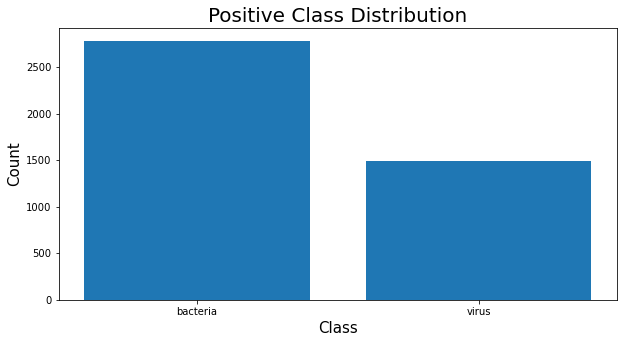

In [58]:
# visualize class distribution

plt.figure(figsize=(10,5))
plt.bar(np.unique(y_pos, return_counts=True)[0], np.unique(y_pos, return_counts=True)[1])
plt.title('Positive Class Distribution', size=20)
plt.xlabel('Class', size=15)
plt.ylabel('Count', size=15)
plt.show()

As before, we'll have to reshape the image array to be compatible with our CNN model.

In [59]:
# reshape X for model

X_pos = X_pos.reshape(X_pos.shape[0], 245, 245, 1)

# check

print(X_pos.shape)

(4273, 245, 245, 1)


We'll now split the dataset into train and test sets, and scale the data.

In [60]:
# split data

X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size=0.25, random_state=42)

# check

print(X_pos_train.shape, y_pos_train.shape)
print(X_pos_test.shape, y_pos_test.shape)

(3204, 245, 245, 1) (3204,)
(1069, 245, 245, 1) (1069,)


In [61]:
# scale

X_pos_train = X_pos_train/255
X_pos_test = X_pos_test/255

# check

print(f'X range: {X_pos_train.min()}-{X_pos_train.max()}')

X range: 0.0-1.0


Also like our multiclass model, we need to encode the `y` arrays from their current string format into numeric arrays with the One Hot Encoder.

In [62]:
# reshape y to encode

y_pos_train = y_pos_train[:, np.newaxis]
y_pos_test = y_pos_test[:, np.newaxis]

In [63]:
# instantiate OHE

ohe = OneHotEncoder(sparse=False)

# encode labels for model

y_pos_train = ohe.fit_transform(y_pos_train)
y_pos_test = ohe.transform(y_pos_test)

# check

print(y_pos_train.shape, y_pos_test.shape)

(3204, 2) (1069, 2)


We now have the datasets processed to compatible form to be modeled. Again we'll use the same model architecture to isolate our changed variables as much as possible, though one difference is necessary - due to an unfortunate artifact of the One Hot Encoder, our output layer must use a two-node architecture with Softmax activation. The model will still act as a binary classification model, and because of this we can also compile with Binary as opposed to Categorical Cross Entropy.

In [64]:
# instantiate model

positive_model = Sequential()

# add layers

positive_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
positive_model.add(MaxPooling2D(pool_size=(2, 2)))
positive_model.add(Dropout(0.25))

positive_model.add(Conv2D(64, (3, 3), activation='relu'))
positive_model.add(MaxPooling2D(pool_size=(2, 2)))
positive_model.add(Dropout(0.25))

# flatten

positive_model.add(Flatten())

# add dense layers

positive_model.add(Dense(128, activation='relu'))
positive_model.add(Dense(64, activation='relu'))
positive_model.add(Dense(2, activation='softmax'))

# summary

positive_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 222784)           

In [65]:
# compile

positive_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [66]:
# train - this will take 15-20 minutes

positive_model.fit(X_pos_train, y_pos_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

Epoch 1/10
22/22 [==============================] - 89s 4s/step - loss: 2.0221 - accuracy: 0.5974 - val_loss: 0.6918 - val_accuracy: 0.6257
Epoch 2/10
22/22 [==============================] - 83s 4s/step - loss: 0.6834 - accuracy: 0.6617 - val_loss: 0.6606 - val_accuracy: 0.6418
Epoch 3/10
22/22 [==============================] - 85s 4s/step - loss: 0.6150 - accuracy: 0.6775 - val_loss: 0.6164 - val_accuracy: 0.6853
Epoch 4/10
22/22 [==============================] - 86s 4s/step - loss: 0.5725 - accuracy: 0.7143 - val_loss: 0.5273 - val_accuracy: 0.7571
Epoch 5/10
22/22 [==============================] - 86s 4s/step - loss: 0.4890 - accuracy: 0.7726 - val_loss: 0.5594 - val_accuracy: 0.7457
Epoch 6/10
22/22 [==============================] - 87s 4s/step - loss: 0.5162 - accuracy: 0.7629 - val_loss: 0.5243 - val_accuracy: 0.7599
Epoch 7/10
22/22 [==============================] - 85s 4s/step - loss: 0.4802 - accuracy: 0.7705 - val_loss: 0.5194 - val_accuracy: 0.7561
Epoch 8/10
22/22 [==

And now we'll evaluate the model as usual.

In [67]:
# score - this will take a few seconds

pos_score = positive_model.evaluate(X_pos_test, y_pos_test, verbose=0)

print(f'Multiclass test loss: {pos_score[0]}')
print(f'Multiclass test accuracy: {pos_score[1]}')

Multiclass test loss: 0.49647119641304016
Multiclass test accuracy: 0.7717493176460266


Compared to our other binary classification models, this is our worst performing model yet. Let's look at the rest of the metrics and see why.

In [68]:
# predict - this will take a few seconds

y_pos_pred = positive_model.predict(X_pos_test)

# revert to class labels

y_pos_pred = ohe.inverse_transform(y_pos_pred)

y_pos_test_labels = ohe.inverse_transform(y_pos_test)

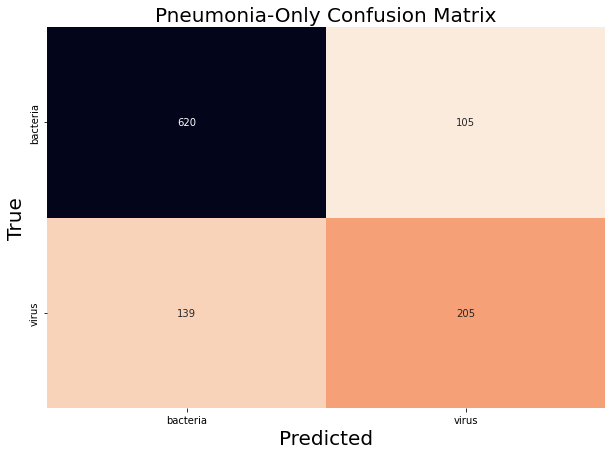

In [69]:
# visualize confusion matrix

positive_cm = confusion_matrix(y_pos_test_labels, y_pos_pred)

plt.figure(figsize=(10,7))
sns.heatmap(positive_cm, xticklabels=['bacteria', 'virus'], yticklabels=['bacteria', 'virus'], fmt='d', annot=True, cbar=False, cmap='rocket_r')
plt.title('Pneumonia-Only Confusion Matrix', size=20)
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

In [70]:
# compare models

print(f'Basic model test accuracy: {score[1]}')
print(f'Weighted model test accuracy: {weighted_score[1]}')
print(f'SMOTE model test accuracy: {smote_score[1]}')
print(f'Multiclass model test accuracy: {mul_pos_score[1]}')
print(f'Positive-Only model test accuracy: {pos_score[1]}')

Basic model test accuracy: 0.943306028842926
Weighted model test accuracy: 0.9419398903846741
SMOTE model test accuracy: 0.9405737519264221
Multiclass model test accuracy: 0.7752732038497925
Positive-Only model test accuracy: 0.7717493176460266


As we previously hypothesized, the model is having a lot of difficulty distinguishing between a `bacteria` case and `virus` case of Pneumonia infection. Compared to our initial baseline model, which improved on a purely majority-class guess by about 25 percentage points, this model was only able to improve by less than 12 percentage points from strictly classifying each image with the majority `bacteria` label.

Based on our evaluation of the multiclass and positive-only binary class models, we can clearly see that the computer is not having much difficulty distinguishing between a `negative` case and either of the two potential `positive` classes, so we can safely say that value is not added by attempting to split the problem into a multiclass dataset. Given our initial attempts to improve on our baseline accuracy and recall were also negligible if not actively harmful, we can move on to some further analysis of our initial model with minimal processing done.

# <a class='anchor' id='11'></a> Visual Evaluation of Best Model

Since our dataset is made up of images, one additional evaluation that can be made of our model is to visually inspect the incorrectly classified images and look for trends or visual cues as to what might be consistently tripping up the model that the computer is missing. To do that we'll need our predictions from our initial model to compare to our actual `y_test` labels. We will need to reshape the `y_pred` variable to work as a mask for the `X_test` image array.

In [71]:
# reshape y_pred

y_pred = y_pred.reshape(1464,)

# check

y_pred.shape

(1464,)

In [72]:
# select misclassified images

misclassified = y_test != y_pred

# check

misclassified.shape

(1464,)

Now that we have our boolean array of incorrectly classified images, we can plot a sample of them and see what might be causing the model problems.

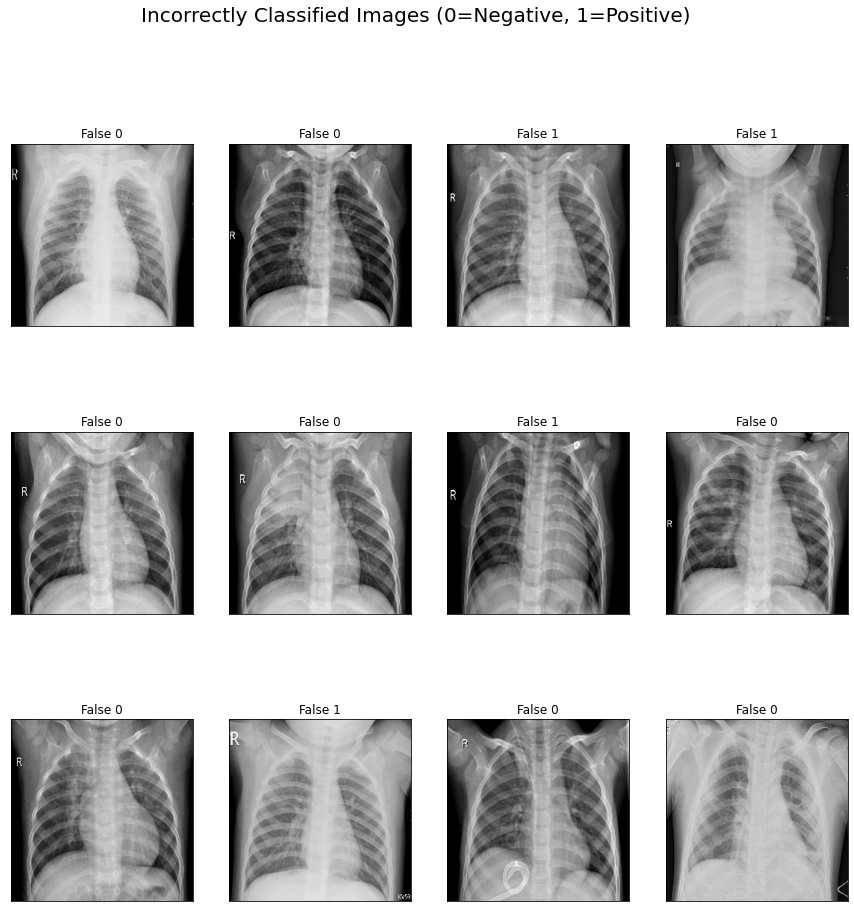

In [73]:
# plot with labels

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 15))

ax = ax.flatten()

for i, image in enumerate(X_test[misclassified][:12]):
    ax[i].imshow(image, cmap='gray')

    prediction = y_pred[misclassified][i]
    
    ax[i].set_title(f'False {prediction}')
    
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])

plt.suptitle('Incorrectly Classified Images (0=Negative, 1=Positive)', size=20)
plt.show()

...And here is where we bump up against the limits of my personal domain expertise. Unfortunately as much as I tried with research, reading, and exploring multiple different subsamples of the misclassified images, at the end of the day I am not professionally trained to read medical images of Pneumonia infections and cannot personally identify any visual patterns that could explain why this set of images is being misclassified. As a smaller microcosm, let's take a look at the first four images in the above sample - two False Negatives, and two False Positives.

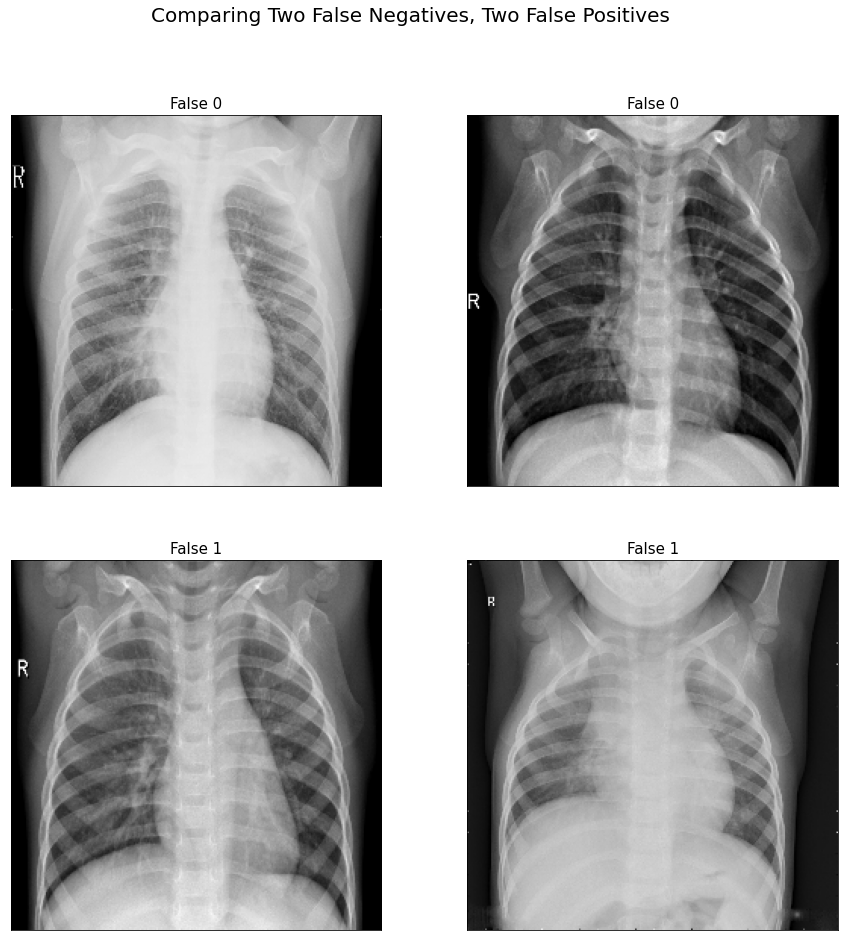

In [74]:
# select fewer samples

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax = ax.flatten()

for i, image in enumerate(X_test[misclassified][:4]):
    ax[i].imshow(image, cmap='gray')

    prediction = y_pred[misclassified][i]
    
    ax[i].set_title(f'False {prediction}', size=15)
    
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])

plt.suptitle('Comparing Two False Negatives, Two False Positives', size=20)
plt.show()

It appears to me that images of differing levels of lung cloudiness (the visual presenation of a Pnuemonia infection in X-ray imaging) are from opposite classes than I would personally expect, and we have examples of each type of misclassification of more or less opaque lung areas. Without considerably more time to study the domain or professional training, at this time I would be unable to personally identify visual characteristics of the misclassified images.

# <a class='anchor' id='12'></a> Summary and Conclusions

My original goal was to create a model that could accurately identify the presence of Pneumonia in X-ray imaging. I succeeded in training a model with a nearly 95% accuracy rate using minimal processing and manipulation of the image data. Although my attempts to improve on this initial model were unfruitful, I did gain surprising insights about what could cause the model to perform worse and what areas caused the computer more difficulty through model iterations. Finally I was able to determine unfortunately that my personal domain expertise is presently somewhat lacking, and effective visual analysis of the images would require further research and study on my part.

Please see the accompanying report for further detailed information regarding future steps and additional project value.